<a href="https://colab.research.google.com/github/DaveMSU/msu_NN_autumn_2020/blob/main/hw3/Practice_task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 7.8MB/s 


In [2]:
!pip install tensorboardX
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings

try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

     |████████████████████████████████| 317kB 9.1MB/s 


In [3]:
#Доступ к диску:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


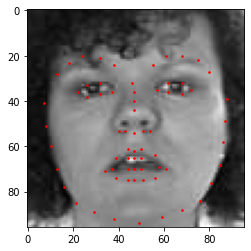

In [4]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('/content/drive/My Drive/dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.values[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('/content/drive/My Drive/dataset/train/', img_name)),
               landmarks)
plt.show()

In [5]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [8]:
train_dataset = FaceLandmarksDataset(csv_file='/content/drive/My Drive/dataset/train/face_landmarks.csv',
                                     root_dir='/content/drive/My Drive/dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='/content/drive/My Drive/dataset/test/face_landmarks.csv',
                                     root_dir='/content/drive/My Drive/dataset/test',
                                     transform=ToTensor())

In [9]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [10]:
from torchvision import models

In [11]:
#ОБУЧЕНИЕ:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
  param.require_grad = False
  
model.fc = torch.nn.Linear(model.fc.in_features, 68 * 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
train_dataloader, test_dataloader = get_data_loaders()

device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)#, weight_decay=0.001)

In [14]:
model.eval()

batch_size = 32

train_loss_history = []
test_loss_history  = []

for epoch in range(60):
  
    model.train()
    losses = []

    for i, (X, y) in enumerate(train_dataloader):

      X = X.numpy()
      X = np.repeat(X[..., np.newaxis], 3, -1).transpose(0,3,1,2)
      X = torch.from_numpy(X)

      X = X.to(device)
      y = y.to(device)
      
      model.zero_grad()
      y_pred = model.forward(X)
      train_loss = loss(y_pred.view(-1, 68, 2), y)
      losses.append(train_loss.item())
      train_loss.backward()
      optimizer.step()
  
      print("\rtrain mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    train_loss_history.append(np.mean(losses))
    model.eval()
    
    print("\rtrain mse: %.4f" % train_loss_history[-1], '\t\tepoch:', epoch+1)




    losses = []
    for i, (X, y) in enumerate(test_dataloader):

      X = X.numpy()
      X = np.repeat(X[..., np.newaxis], 3, -1).transpose(0,3,1,2)
      X = torch.from_numpy(X)

      X = X.to(device)
      y = y.to(device)
      
      y_pred = model.forward(X)
      test_loss = loss(y_pred.view(-1, 68, 2), y)
      losses.append(test_loss.item())
      
      print("\rtest mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    test_loss_history.append(np.mean(losses))
    print("\rtest mse: %.4f" % test_loss_history[-1], '\t\tepoch:', epoch+1)
    print()

train mse: 1153.0680 		epoch: 1
test mse: 150.5304 		epoch: 1

train mse: 32.5490 		epoch: 2
test mse: 17.5747 		epoch: 2

train mse: 14.4632 		epoch: 3
test mse: 16.0340 		epoch: 3

train mse: 14.2879 		epoch: 4
test mse: 20.3055 		epoch: 4

train mse: 14.0994 		epoch: 5
test mse: 19.3928 		epoch: 5

train mse: 13.4512 		epoch: 6
test mse: 13.6451 		epoch: 6

train mse: 10.8671 		epoch: 7
test mse: 11.1612 		epoch: 7

train mse: 9.3891 		epoch: 8
test mse: 15.1737 		epoch: 8

train mse: 8.4776 		epoch: 9
test mse: 9.5067 		epoch: 9

train mse: 7.6580 		epoch: 10
test mse: 11.1873 		epoch: 10

train mse: 5.9680 		epoch: 11
test mse: 5.9960 		epoch: 11

train mse: 5.0490 		epoch: 12
test mse: 5.6298 		epoch: 12

train mse: 4.4752 		epoch: 13
test mse: 5.0166 		epoch: 13

train mse: 3.8750 		epoch: 14
test mse: 4.7412 		epoch: 14

train mse: 3.3867 		epoch: 15
test mse: 4.1707 		epoch: 15

train mse: 3.0933 		epoch: 16
test mse: 4.1853 		epoch: 16

train mse: 2.6656 		epoch: 17
test mse:

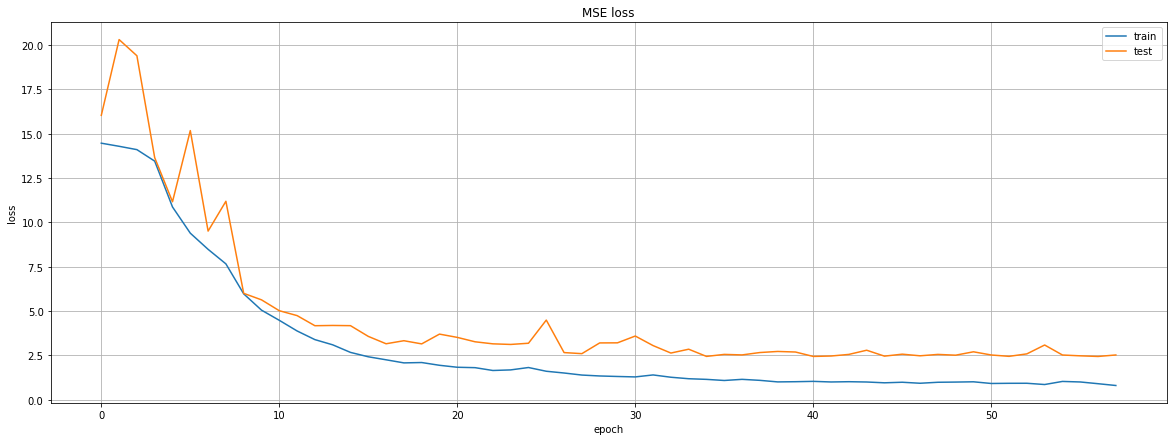

In [24]:
fig, ax = plt.subplots(1, figsize=(20,7))

ax.plot(train_loss_history[2:], label='train')
ax.plot(test_loss_history[2:],  label='test')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('MSE loss')
ax.legend()
ax.grid()

In [30]:
y_pred.shape

(2, 136)

(2, 96, 96)


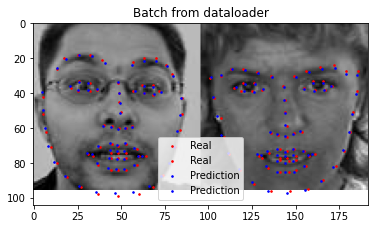

In [31]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
X, y = images_batch

X = X.cpu().numpy()
X = np.repeat(X[..., np.newaxis], 3, -1).transpose(0,3,1,2)
X = torch.from_numpy(X)

X = X.to(device)
y = y.to(device)

y_pred = model(X)
y_pred = y_pred.data.cpu().numpy().reshape(-1, 68, 2)
show_landmarks_batch(images_batch, y_pred)

TEST (MSE) score: 2.5212 